# Summary
learn a reduced model for when you apply the POD seperately. 


# To do
* apply POD seperately on V and theta.
* I think it is better to apply the ML model without having the dissipation data and see the one iteration results. 
* Generated data to impose dissipation for this .
* update the model 

# Load Data

In [1]:
import numpy as np
import sys
sys.path.append('./../')
import torch
import torch.nn as nn
import torch.optim as optim
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from ProcessFunctions import find_Aisv2,Find_a_i,find_Aisv2_onlyv
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch.nn.functional as F
from scipy.interpolate import interp1d
import seaborn as sns 
import cte_eq

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [3]:
T_final=5.5e3
Ntout=cte_eq.Ntout
Nxout=cte_eq.Nxout
drs=0.012
data_dir='/central/groups/astuart/hkaveh/Data/LearnROM/transfer/MainSimulation2D_Tf'+str(T_final)+"Nt="+str(Ntout)+"Nx="+str(Nxout)+'PODonlyonV'+'drs'+str(drs)+".npz"
PODmodes=np.load(data_dir)
U_v=PODmodes['U']
S_v=PODmodes['S']
VT_v=PODmodes['VT']
q_bar_v=PODmodes['q_bar']

In [4]:
# Loading POD modes


data_dir='/central/groups/astuart/hkaveh/Data/LearnROM/transfer/MainSimulation2D_Tf'+str(T_final)+"Nt="+str(Ntout)+"Nx="+str(Nxout)+'PODonlyontheta'+'drs'+str(drs)+".npz"

PODmodes=np.load(data_dir)
U_theta=PODmodes['U']
S_theta=PODmodes['S']
VT_theta=PODmodes['VT']
q_bar_theta=PODmodes['q_bar']

In [5]:
# radi_outer=25
# radi_inner=24


In [6]:
# Loading data from "/central/groups/astuart/hkaveh/Data/LearnROM/transfer/SampleSimulation_Tf_2D'+str(T_final_run)+"Nt="+str(cte_eq.Ntout)+"N_m"+str(N_m)+"coeff"+str(coeff)+"number"+str(index)"
T_final_run = 350 # each initial condition is simulated for 250 years
Nt=5     # it is recorded every Nt time stes
N_m_v=20 # number of modes that they have considered
N_m_theta=20 # number of modes that they have considered
coeff=1 # How the inital conditions are from the chaotic attractor
number=10 # Which one do you want to load
N_cut=2000
# loading time series:
N_m_load=30

X_full=np.empty((1,N_m_load*2))
Y_full=np.empty((1,N_m_load*2))


for number in range(35):
    data_dir='/central/groups/astuart/hkaveh/Data/LearnROM/transfer/SampleSimulation_Tf_2D'+str(T_final_run)+"Nt="+str(cte_eq.Ntout)+"N_m"+str(N_m_load)+"coeff"+str(coeff)+"number"+str(number)+".npz"
    data_smaple=np.load(data_dir)
    V_ox=data_smaple['array1']
    theta_ox=data_smaple['array2']
    t_ox=data_smaple['array3']

    # We work with log10 of V_ox and theta_ox:
    V_ox=np.log10(V_ox)
    theta_ox=np.log10(theta_ox)

    A_v,P_v=find_Aisv2_onlyv(U_v,V_ox,q_bar_v,N_m_load) # you dont need P in general, but I need it to check if I do everything correctly
    A_theta,P_theta=find_Aisv2_onlyv(U_theta,theta_ox,q_bar_theta,N_m_load)
    # concatenating the two arrays
    A=np.concatenate((A_v,A_theta),axis=1)
    X_onesimulation=A[:-1,:]         # current step
    Y_onesimulation=A[1:,:]-A[:-1,:] # next step minus the current step
    X_full=np.append(X_full,X_onesimulation,axis=0)
    Y_full=np.append(Y_full,Y_onesimulation,axis=0)
    print("number is " +str(number)+ " size of data in this simulation is " +str(X_onesimulation.shape[0])+" total size is " + str(X_full.shape[0]))

# removing the first row which is empty
X_full=X_full[1:,:]
Y_full=Y_full[1:,:]

# print(np.max(X_full))
print(np.max(Y_full))
# Loading the the numpy arrays Input and Output which are generated for imposing dissipiation far away from the attractor
# # commenting here:
# data_dir="/central/groups/astuart/hkaveh/Data/LearnROM/EllipticShell_radi_outer"+str(radi_outer)+"radi_inner"+str(radi_inner)+"PODappliedseperately.npz"

# data_smaple=np.load(data_dir)
# Input_X=data_smaple['Input']
# Output_Y=data_smaple['Output']
# # appending the Input_X to the X_full and Output_Y to the Y_full
# # appending the Input_X to the X_full and Output_Y to the Y_full, but append from the begining of the array
# print(np.max(Output_Y))
# X_full=np.append(Input_X,X_full,axis=0)
# Y_full=np.append(Output_Y,Y_full,axis=0)
# # untill here

# deleting some colomns from X_full and Y_full that are should not be included based on N_m_v and N_m_theta
# index of the columns that should be deleted
index_delete=np.array([])
if N_m_v<N_m_load:
    index_delete=np.append(index_delete,np.arange(N_m_v,N_m_load))
if N_m_theta<N_m_load:
    index_delete=np.append(index_delete,np.arange(N_m_load+N_m_theta,2*N_m_load))


# Convert the array elements to integers
index_delete = index_delete.astype(int)

X_full=np.delete(X_full,index_delete,axis=1)
Y_full=np.delete(Y_full,index_delete,axis=1)
print("index of the columns that are deleted are:")
print(index_delete)

print(X_full.shape)
print("size of the data is " +str(X_full.shape[0]))


number is 0 size of data in this simulation is 358 total size is 359
number is 1 size of data in this simulation is 420 total size is 779
number is 2 size of data in this simulation is 198 total size is 977
number is 3 size of data in this simulation is 260 total size is 1237
number is 4 size of data in this simulation is 326 total size is 1563
number is 5 size of data in this simulation is 304 total size is 1867
number is 6 size of data in this simulation is 277 total size is 2144
number is 7 size of data in this simulation is 257 total size is 2401
number is 8 size of data in this simulation is 267 total size is 2668
number is 9 size of data in this simulation is 291 total size is 2959
number is 10 size of data in this simulation is 258 total size is 3217
number is 11 size of data in this simulation is 362 total size is 3579
number is 12 size of data in this simulation is 439 total size is 4018
number is 13 size of data in this simulation is 300 total size is 4318
number is 14 size o

In [8]:
(index_delete)

array([20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 50, 51, 52, 53, 54, 55, 56,
       57, 58, 59])

Text(0.5, 1.0, 'Histogram of the norm of X_full along each row')

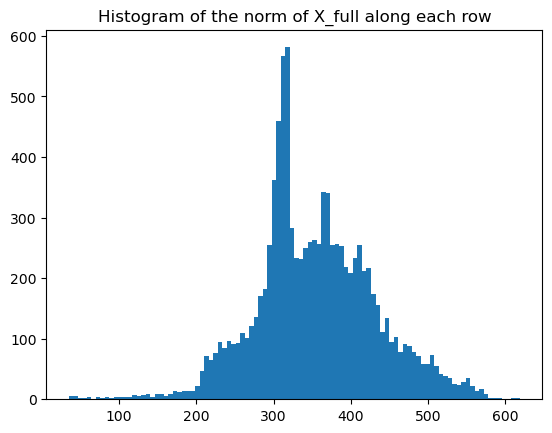

In [10]:
# Plot the histogram of the  norm of X_full along each row
norm_X_full=np.linalg.norm(X_full,axis=1)
plt.hist(norm_X_full,bins=100)
plt.title("Histogram of the norm of X_full along each row")

Text(0.5, 1.0, 'Histogram of the norm of X_full along each row')

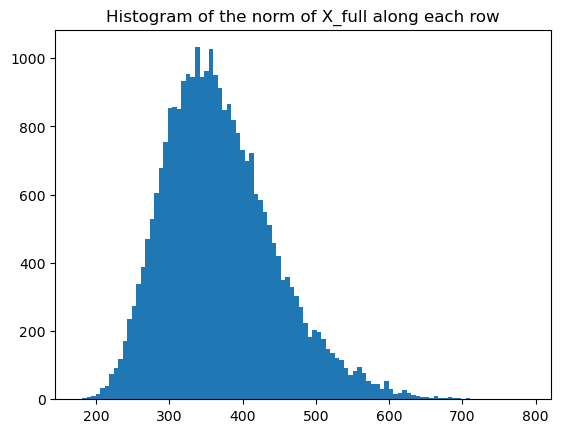

: 

In [8]:
# # Plot the histogram of the  norm of X_full along each row
# norm_X_full=np.linalg.norm(Input_X,axis=1)
# plt.hist(norm_X_full,bins=100)
# plt.title("Histogram of the norm of X_full along each row")

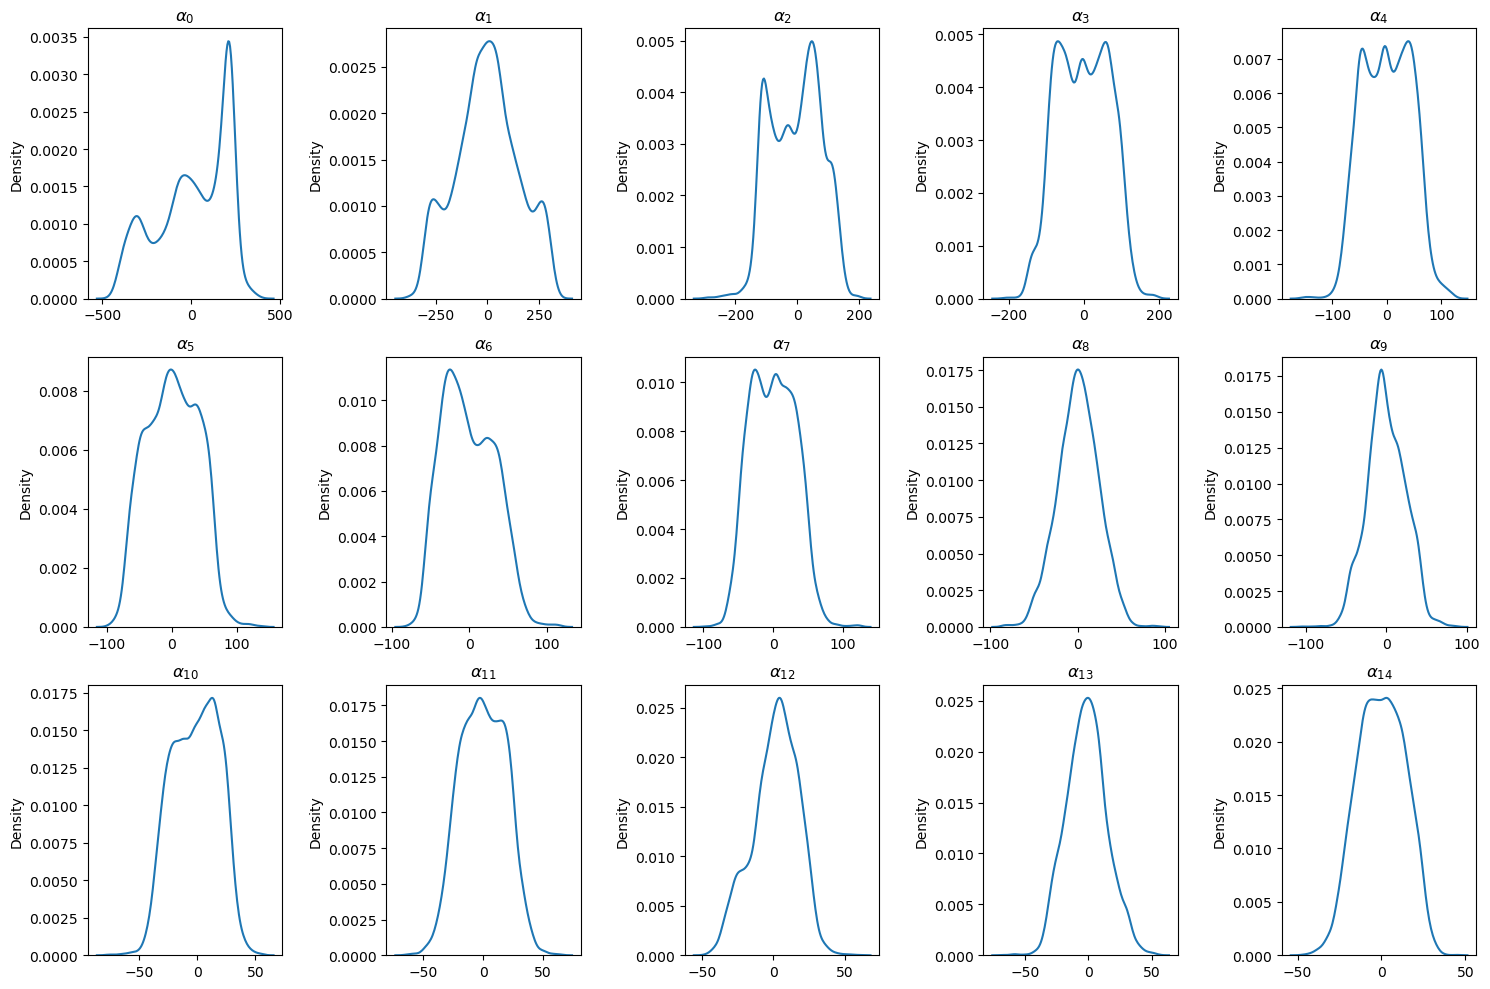

In [11]:
# Create a figure and axis objects
fig, axs = plt.subplots(3, 5, figsize=(15, 10))

# Flatten the axs array so that we can iterate over it easily
axs = axs.flatten()

# Plot the KDE plot for each column of X_full
for i in range(15):
    sns.kdeplot(X_full[:, i], ax=axs[i])
    axs[i].set_title(r'$\alpha_{{{}}}$'.format(i))

# Adjust layout and show plot
plt.tight_layout()
plt.show()



# Preprocessing Data

In [22]:
X_cut=X_full[-N_cut:,:]
Y_cut=Y_full[-N_cut:,:]
X=X_full[1:-N_cut,:] # Also, removing the first element
Y=Y_full[1:-N_cut,:] 
# rescale
# # comment from here:
max_X=np.max(X)
max_y=np.max(Y)

X=X/max_X
Y=Y/max_y
X_cut=X_cut/max_X
Y_cut=Y_cut/max_y
# # untill here




In [23]:
# print(max_X)
# print(max_y)

In [24]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
Y_train_tensor = torch.tensor(Y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
Y_test_tensor = torch.tensor(Y_test, dtype=torch.float32)
# Create datasets and dataloaders
train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, Y_test_tensor)
batch_size = 64
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Defining Model

In [26]:
# %% Defining model
class Forwardmap(nn.Module):
    def __init__(self,N_m):
        super().__init__()
        self.hidden1=nn.Linear(N_m,2*N_m)
        self.act1=nn.Tanh()
        self.hidden2=nn.Linear(2*N_m,4*N_m)
        self.act2=nn.Tanh()
        self.hidden3=nn.Linear(4*N_m,4*N_m)
        self.act3=nn.Tanh()
        self.hidden4=nn.Linear(4*N_m,2*N_m)
        self.act4=nn.Tanh()
        self.output=nn.Linear(2*N_m,N_m)

    def forward(self,x):
        x=self.act1(self.hidden1(x))
        x=self.act2(self.hidden2(x))
        x=self.act3(self.hidden3(x))
        x=self.act4(self.hidden4(x))
        x=(self.output(x))
        return x

model=Forwardmap(N_m_v+N_m_theta)
print(model)
# Move the model to GPU
model = model.to(device)

loss_fn=nn.MSELoss()
optimizer=optim.Adam(model.parameters(),lr=0.002)
# Define the scheduler for changing learning rate every 20 epochs
lr_decay_factor = 0.5
lr_scheduler_step = 50
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=lr_scheduler_step, gamma=lr_decay_factor)

Forwardmap(
  (hidden1): Linear(in_features=40, out_features=80, bias=True)
  (act1): Tanh()
  (hidden2): Linear(in_features=80, out_features=160, bias=True)
  (act2): Tanh()
  (hidden3): Linear(in_features=160, out_features=160, bias=True)
  (act3): Tanh()
  (hidden4): Linear(in_features=160, out_features=80, bias=True)
  (act4): Tanh()
  (output): Linear(in_features=80, out_features=40, bias=True)
)


# Optimize, save and evaluate the ML model

In [27]:
num_epochs=250
for epoch in range(num_epochs):
    model.train()
    for inputs,targets in train_dataloader:
        # Move inputs and targets to GPU
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs=model(inputs)
        loss=loss_fn(outputs,targets)
        loss.backward()
        optimizer.step()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.8f}')
    scheduler.step()
    current_lr = optimizer.param_groups[0]['lr']
    print(current_lr)

Epoch [1/250], Loss: 0.00023485
0.002
Epoch [2/250], Loss: 0.00017643
0.002
Epoch [3/250], Loss: 0.00024534
0.002
Epoch [4/250], Loss: 0.00407871
0.002
Epoch [5/250], Loss: 0.00020846
0.002
Epoch [6/250], Loss: 0.00021031
0.002
Epoch [7/250], Loss: 0.00107463
0.002
Epoch [8/250], Loss: 0.00116213
0.002
Epoch [9/250], Loss: 0.00015196
0.002
Epoch [10/250], Loss: 0.00022496
0.002
Epoch [11/250], Loss: 0.00024109
0.002
Epoch [12/250], Loss: 0.00060067
0.002
Epoch [13/250], Loss: 0.00033808
0.002
Epoch [14/250], Loss: 0.00009305
0.002
Epoch [15/250], Loss: 0.00018307
0.002
Epoch [16/250], Loss: 0.00011184
0.002
Epoch [17/250], Loss: 0.00042543
0.002
Epoch [18/250], Loss: 0.00071392
0.002
Epoch [19/250], Loss: 0.00012626
0.002
Epoch [20/250], Loss: 0.00023223
0.002
Epoch [21/250], Loss: 0.00021328
0.002
Epoch [22/250], Loss: 0.00016761
0.002
Epoch [23/250], Loss: 0.00013722
0.002
Epoch [24/250], Loss: 0.00014008
0.002
Epoch [25/250], Loss: 0.00024385
0.002
Epoch [26/250], Loss: 0.00058044
0

In [28]:
# Evaluate the model on the test set
model.eval()
total_loss = 0.0
with torch.no_grad():
    for inputs, targets in test_dataloader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)
        total_loss += loss.item() * inputs.size(0)

mean_loss = total_loss / len(test_dataset)
print(f'Test Loss: {mean_loss:.4f}')

Test Loss: 0.0003


In [29]:
# save the model in the group directory
version=0
torch.save(model.state_dict(), "/central/groups/astuart/hkaveh/Data/LearnROM/Earthquake2D_ROM_POD_separate_onV_theta"+str(version)+"N_m_v"+str(N_m_v)+"N_m_theta"+str(N_m_theta)+".pt")

cpu


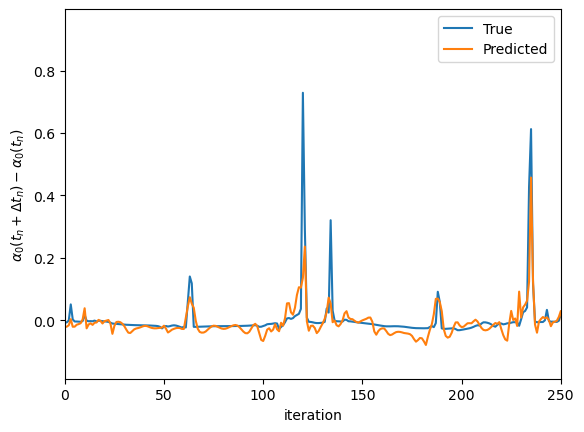

In [30]:
X_cut_tensor = torch.tensor(X_cut, dtype=torch.float32)
device = torch.device( "cpu")
print(device)
model.to(device)
index=np.linspace(1,N_cut-1,N_cut-1)
Pred=model(X_cut_tensor)
plt.plot(Y_cut[:,0],label='True')
plt.plot(Pred.detach().numpy()[:,0],label='Predicted')
plt.xlabel('iteration')
plt.ylabel(r'$\alpha_0(t_n+\Delta t_n)-\alpha_0(t_n)$')
plt.xlim(left=0,right=250)
plt.legend()

cpu


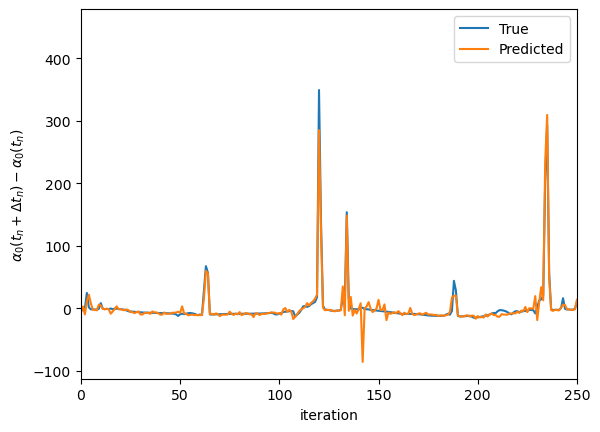

In [21]:
X_cut_tensor = torch.tensor(X_cut, dtype=torch.float32)
device = torch.device( "cpu")
print(device)
model.to(device)
index=np.linspace(1,N_cut-1,N_cut-1)
Pred=model(X_cut_tensor)
plt.plot(Y_cut[:,0],label='True')
plt.plot(Pred.detach().numpy()[:,0],label='Predicted')
plt.xlabel('iteration')
plt.ylabel(r'$\alpha_0(t_n+\Delta t_n)-\alpha_0(t_n)$')
plt.xlim(left=0,right=250)
plt.legend()


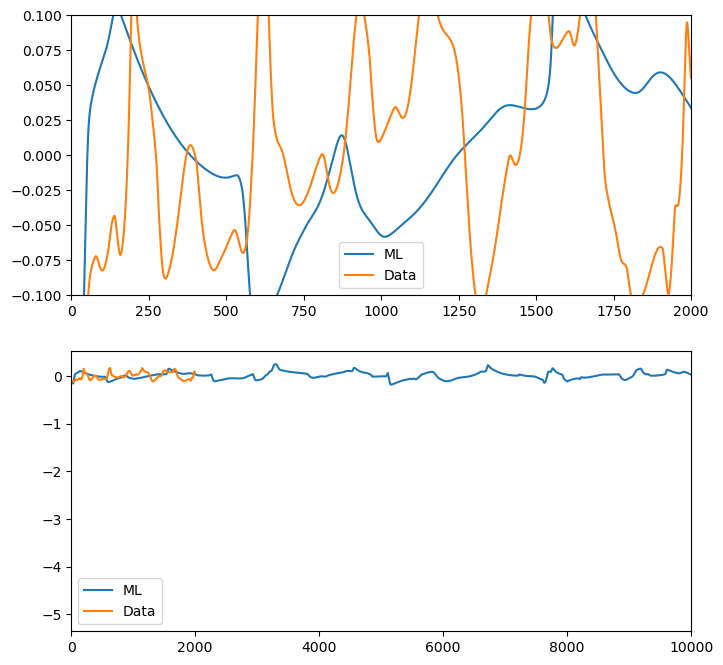

In [21]:
xk=X_cut[0,:] # Picking one initial condition, this can be any point inside the chaotic attractor
N_m=N_m_v+N_m_theta
xk=torch.tensor(xk, dtype=torch.float32)
forecast=xk.detach().numpy().reshape(N_m,1)
for index in range(50*N_cut):
    ykp1=(model(xk))*(max_y/max_X)
    xkp1=ykp1+xk
    numpy_vector = xkp1.detach().numpy().reshape(N_m,1)
    forecast = np.hstack([forecast, numpy_vector])
    xk=xkp1

fig, (ax1,ax2) = plt.subplots(2,1 , figsize=(8, 8))
ax1.plot(forecast[0,:],label='ML')
ax1.plot(X_cut[:,0],label='Data')
ax1.set_xlim([0,2000])
ax1.set_ylim([-0.1,0.1])
ax1.legend()
# saving figure
ax2.plot(forecast[0,:],label='ML')
ax2.plot(X_cut[:,0],label='Data')
ax2.set_xlim([0,5*N_cut])
ax2.legend()

#plt.savefig('./Figs/Forecast.png')


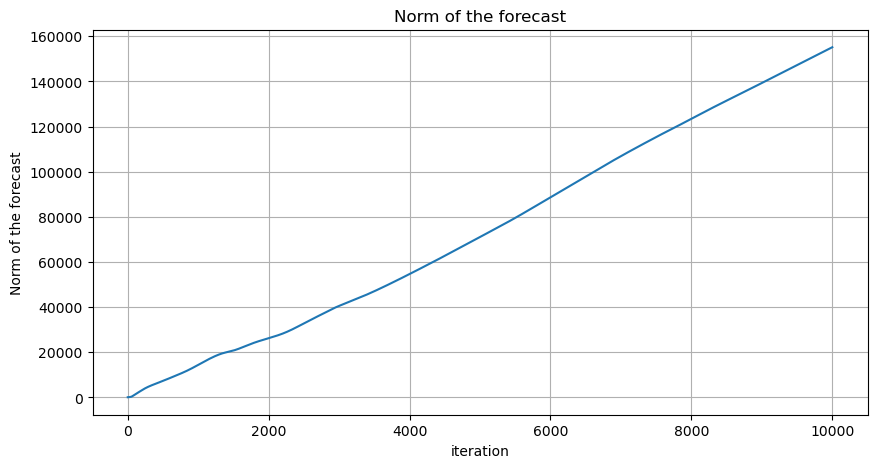

In [17]:
# I want to plot two figures here. 
# figure 1
# plot the time sereis of the norm of forecast
norm_forecast=np.linalg.norm(forecast,axis=0)
# I want to also grid the plot very fine
plt.figure(figsize=(10,5))
# set xlim
plt.xlim([0,1500])
plt.ylim([0,200])

plt.plot(norm_forecast*max_X)
plt.title("Norm of the forecast")
plt.xlabel("iteration")
plt.ylabel("Norm of the forecast")
plt.grid(True)
plt.show()




In [21]:
alpha=forecast*max_X
alpha_v=alpha[:N_m_v,:]
alpha_theta=alpha[N_m_v:,:]

In [20]:
# Loading POD modes for V and Theta
N_m_v_load=30
N_m_theta_load=30
data_dir="/central/groups/astuart/hkaveh/Data/LearnROM/MainSimulation_Tf600Nt=5PODonlyonV.npz"
PODmodes=np.load(data_dir)
U_v=PODmodes['U']
S_v=PODmodes['S']
VT_v=PODmodes['VT']
q_bar_v=PODmodes['q_bar']
Sigma_v=np.diagonal(S_v)
Nt2=VT_v.shape[0]
Lambda_v=Sigma_v**2/Nt2
Lambda_v=np.atleast_2d(Lambda_v[:N_m_v_load])
Sigma_v=(np.sqrt(Lambda_v))


data_dir="/central/groups/astuart/hkaveh/Data/LearnROM/MainSimulation_Tf600Nt=5PODonlyontheta.npz"
PODmodes=np.load(data_dir)
U_theta=PODmodes['U']
S_theta=PODmodes['S']
VT_theta=PODmodes['VT']
q_bar_theta=PODmodes['q_bar']
Sigma_theta=np.diagonal(S_theta)
Nt2=VT_theta.shape[0]
Lambda_theta=Sigma_theta**2/Nt2
Lambda_theta=np.atleast_2d(Lambda_theta[:N_m_theta_load])
Sigma_theta=(np.sqrt(Lambda_theta))




In [33]:
Sigma_v=Sigma_v[0,:N_m_v]
Sigma_theta=Sigma_theta[0,:N_m_theta]

In [40]:
normalized_alpha_v=alpha_v/Sigma_v[:, np.newaxis]
normalized_alpha_theta=alpha_theta/Sigma_theta[:, np.newaxis]

In [41]:
# apppend the normalized_alpha_v and normalized_alpha_theta
normalized_alpha=np.append(normalized_alpha_v,normalized_alpha_theta,axis=0)

In [42]:
normalized_alpha.shape

(40, 10001)

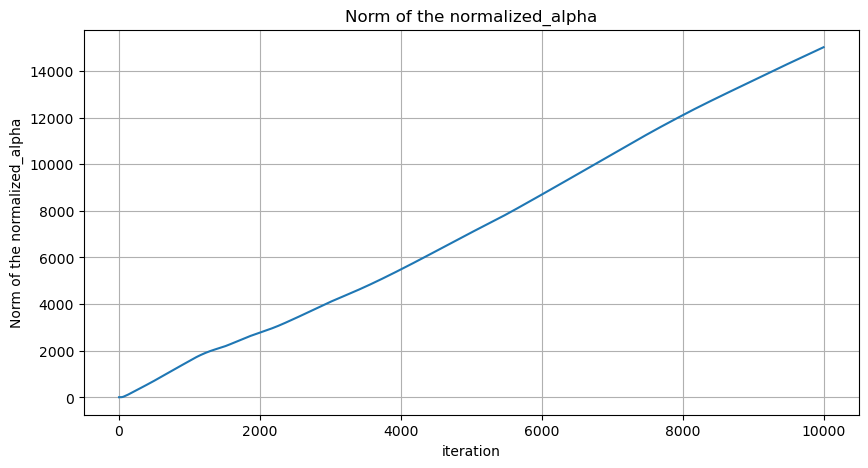

In [43]:
# plot the timeseries of the norm of the normalized_alpha
norm_normalized_alpha=np.linalg.norm(normalized_alpha,axis=0)
plt.figure(figsize=(10,5))
plt.plot(norm_normalized_alpha)
plt.title("Norm of the normalized_alpha")
plt.xlabel("iteration")
plt.xlim([0,1500])
plt.ylim([0,100])

plt.ylabel("Norm of the normalized_alpha")
plt.grid(True)
plt.show()
